# Story 4:
## What are the factors that determine data scientist salary?


Data Source: https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries

Title: Data Science Salary and Employment Dataset

Description: This dataset contains information about salaries and employment characteristics across various roles and industries. It includes data on work year, experience level, employment type, job title, salary, salary currency, salary converted to USD, employee residence, remote work ratio, company location, and company size.

Columns:

work_year: The year the salary was paid.
experience_level: Entry-level / Junior, Mid-level / Intermediate, Senior-level / Expert, Executive-level / Director.
employment_type: Part-time, Full-time, Contract, Freelance.
job_title: The role worked in during the year.
salary: Total gross salary amount paid.
salary_currency: Currency of the salary paid as an ISO 4217 currency code.
salary_in_usd: Salary in USD (FX rate divided by average USD rate for the respective year).
employee_residence: Employee's primary country of residence during the work year as an ISO 3166 country code.
remote_ratio: Overall amount of work done remotely (0 for no remote work, 50 for partially remote, 100 for fully remote).
company_location: Country of the employer's main office or contracting branch as an ISO 3166 country code.
company_size: Average number of people that worked for the company during the year (S for less than 50 employees, M for 50 to 250 employees, L for more than 250 employees).
Acknowledgements: Special thanks to ai-jobs.net Salaries for aggregating this data!

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import re
import plotly.express as px
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/stormwhale/data-mines/refs/heads/main/ds_salaries.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


# Graph 1

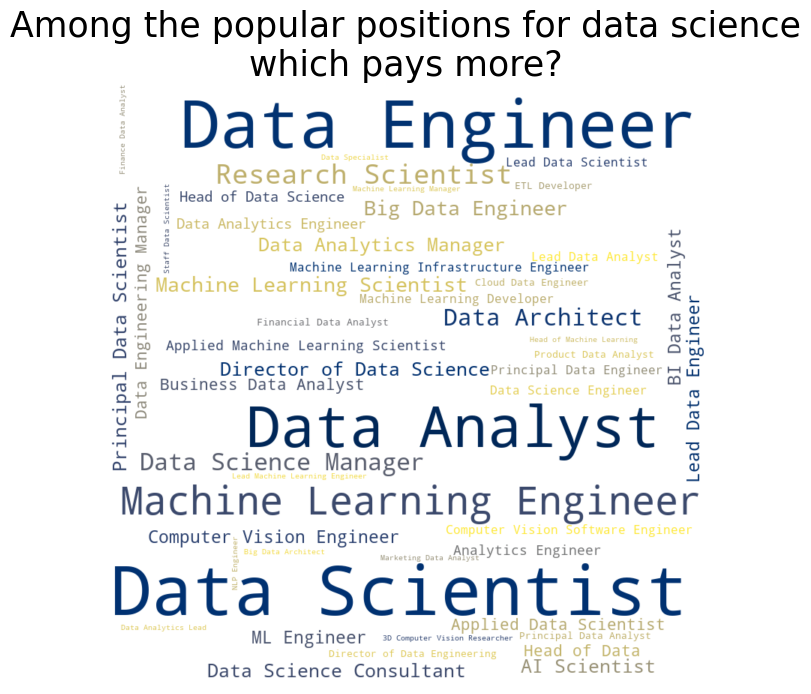

In [56]:
freq = df['job_title'].value_counts().to_dict()

# Generate WordCloud
wordcloud = WordCloud(
    width=800,
    height=800,
    colormap='cividis',
    background_color='white',
    prefer_horizontal=0.8,
    min_font_size=10,
    max_words=200,
    random_state=42
).generate_from_frequencies(freq)

plt.figure(figsize=(6, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Among the popular positions for data science\nwhich pays more?', fontsize=25)
plt.show()

# Graph 2

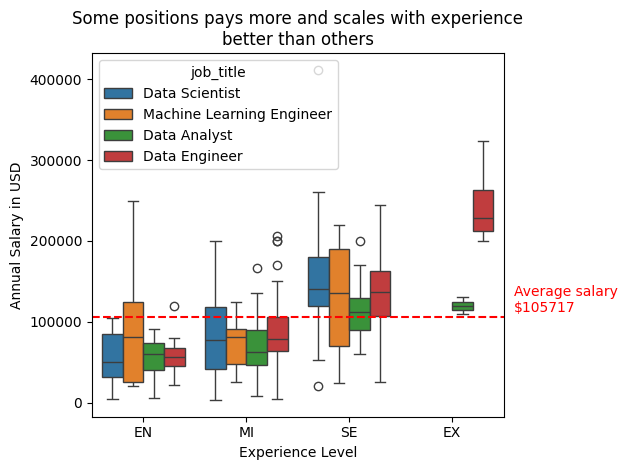

In [23]:
# Top 4 job titles
top4_job_titles = df['job_title'].value_counts().sort_values(ascending=False).head(4).index.tolist()
top_titles_df = df[df['job_title'].isin(top4_job_titles)]

avg_company = top_titles_df.groupby('company_location')['salary_in_usd'].mean().sort_values(ascending=False)
avg_employee = top_titles_df.groupby('employee_residence')['salary_in_usd'].mean().sort_values(ascending=False)
avg_sal = top_titles_df['salary_in_usd'].mean()

#Average Salary:
avg_salary = df['salary_in_usd'].mean()

#plot boxplots:
sns.boxplot(data=top_titles_df,
            x = 'experience_level',
            y = 'salary_in_usd',
            order= ['EN', 'MI', 'SE', 'EX'],
            hue='job_title')
plt.axhline(avg_sal, color='red', linestyle='--')
plt.text(x = 3.6, y = avg_salary, s=f'Average salary\n${avg_sal:.0f}', color = 'red')
plt.xlabel('Experience Level')
plt.ylabel('Annual Salary in USD')
plt.title('Some positions pays more and scales with experience\nbetter than others')
plt.tight_layout()
plt.show()

# Graph 3

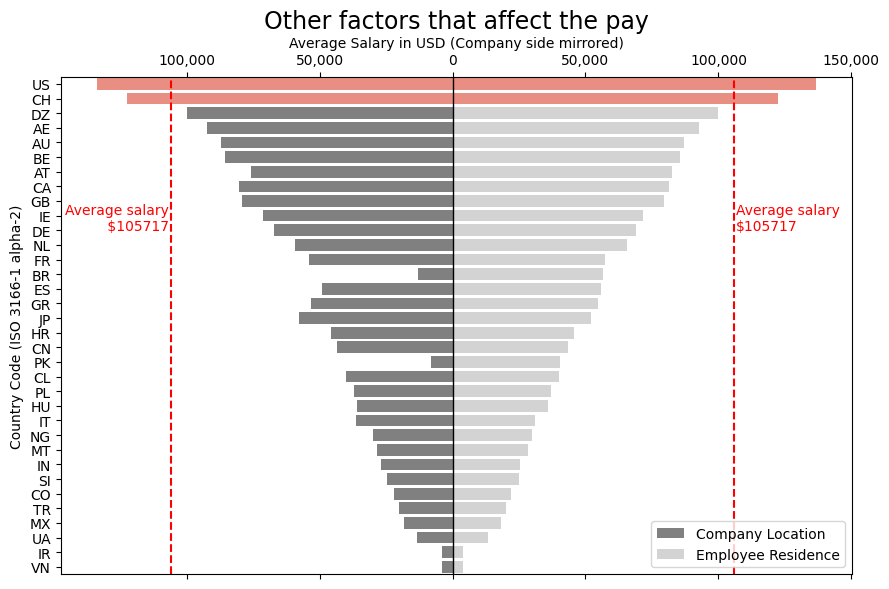

In [22]:
from matplotlib.ticker import FuncFormatter

# Common countries
plot_df = pd.concat([avg_company, avg_employee], axis=1, join='inner')
plot_df.columns = ['Company_Location', 'Employee_Residence']
plot_df['Company_Location'] = -plot_df['Company_Location']
plot_df = plot_df.sort_values(by='Employee_Residence', ascending=False).reset_index().rename(columns={'index': 'Country'})

# --- Plot ---
plt.figure(figsize=(9, 6))
order = plot_df['Country']

# Base layers
sns.barplot(x='Company_Location', y='Country', data=plot_df, color='grey', label='Company Location', order=order)
sns.barplot(x='Employee_Residence', y='Country', data=plot_df, color='lightgrey', label='Employee Residence', order=order)

# Highlight above-average
sns.barplot(x='Company_Location', y='Country',
            data=plot_df[plot_df['Company_Location'] < -avg_sal],
            color='salmon', order=order)
sns.barplot(x='Employee_Residence', y='Country',
            data=plot_df[plot_df['Employee_Residence'] > avg_sal],
            color='salmon', order=order)

# Lines
plt.axvline(x=0, color='black', linewidth=1)
plt.axvline(x=avg_sal, color='red', linestyle='--')
plt.axvline(x=-avg_sal, color='red', linestyle='--')

plt.text(x=avg_sal+1000, y=10, s=f'Average salary\n${avg_sal:.0f}', color='red')
plt.text(x=-avg_sal-1000, y=10, s=f'Average salary\n ${avg_sal:.0f}', color='red', ha='right')
from matplotlib.ticker import FuncFormatter
#Define the absolute x-ticks:
def abs_xticks(x, pos):
    return f'{abs(x):,.0f}'

# Labels
plt.tick_params(axis='x', labeltop=True, labelbottom=False, top=True) #Move axis to the top
plt.title('Other factors that affect the pay', fontsize=17)
plt.xlabel('Average Salary in USD (Company side mirrored)')
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.set_major_formatter(FuncFormatter(abs_xticks))
plt.ylabel('Country Code (ISO 3166-1 alpha-2)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


# Graph 4:

Text(0.5, 1.0, 'Company size impacts annual salary')

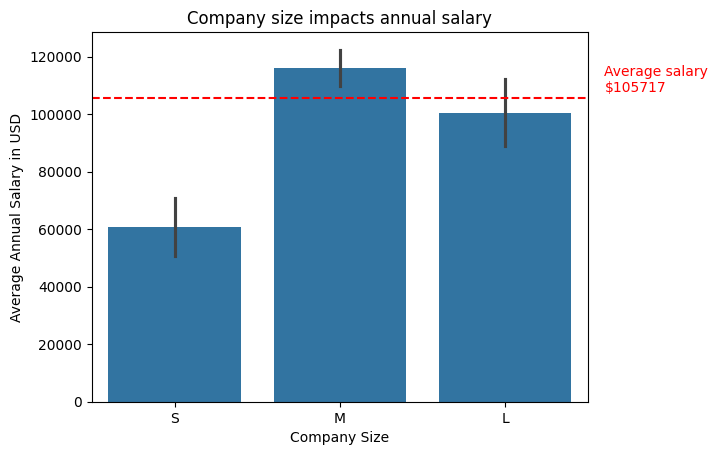

In [25]:
sns.barplot(top_titles_df,
            x='company_size',
            y='salary_in_usd',
            order=['S', 'M', 'L'])
plt.axhline(avg_sal, color='red', linestyle='--')
plt.text(x = 2.6, y = avg_sal + 2000, s=f'Average salary\n${avg_sal:.0f}', color = 'red')
plt.xlabel('Company Size')
plt.ylabel('Average Annual Salary in USD')
plt.title('Company size impacts annual salary')

In [31]:
#Train and fit a XGB model to predict salary and to generate the feature importance plot:
X = top_titles_df.drop(columns=['salary_in_usd', 'salary_currency', 'salary'], axis=1)
y = top_titles_df['salary_in_usd']

#Perform train-test split:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing categorical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numeric_features = X.select_dtypes(include=['int64']).columns.tolist()

# Create ColumnTransformer for preprocessing:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numeric_features)
    ]
)

# Fit and transform the training data, transform the test data
xgb_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('xgb', XGBRegressor(random_state=42, objective='reg:squarederror'))
    ])

xgb_param = {
    'xgb__n_estimators': [500, 800, 1000, 1200, 1500],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__gamma': [0, 0.1, 0.3, 0.5],     
    'xgb__reg_alpha': [0, 0.1, 0.5, 1]
}

xgb_grid = GridSearchCV(estimator=xgb_pipeline, param_grid=xgb_param, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
xgb_grid.fit(X_train, y_train)

print('-'*80)
print(f'Best RMSE for training set: {np.sqrt(-xgb_grid.best_score_):.2f}')
print(f'Best parameters: {xgb_grid.best_params_}')

# Predict on the test set:
xgb_best = xgb_grid.best_estimator_
y_pred = xgb_best.predict(X_test)

# Evaluate the model:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error for test set: {rmse:.2f}')
print('-'*80)

# Feature importance plot:
importance = xgb_best.named_steps['xgb'].get_booster().get_score(importance_type='gain')

#Get feature names:
feature_names = xgb_best.named_steps['preprocessor'].get_feature_names_out()

#Feature name mapping:
importance_mapped = {feature_names[int(k[1:])]: v for k, v in importance.items()}

#Form a df for importance plot:
importance_df = (pd.DataFrame({
    'Feature': list(importance_mapped.keys()),
    'Importance': list(importance_mapped.values())}).sort_values('Importance', ascending=False)
)



--------------------------------------------------------------------------------
Best RMSE for training set: 39135.29
Best parameters: {'xgb__gamma': 0, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 800, 'xgb__reg_alpha': 0.5}
Root Mean Squared Error for test set: 34154.77
--------------------------------------------------------------------------------


# Graph 5

In [53]:
#Data cleaning on feature names:
importance_df['Feature'] = importance_df['Feature'].str.replace(r'cat__', '', regex=True)
importance_df['Feature'] = importance_df['Feature'].str.replace('_', ' ')


#Plot:
fig = px.treemap(
    importance_df.head(7),
    path=['Feature'],
    values='Importance',
    title='The most importance factor for salary is <b>Employee Residence in the U.S.</b> based on XGB model',
    subtitle='Other secondary importance factors are experience level, and job positions')

fig.update_traces(
    root_color="lightgrey",
    textinfo = 'label',
    textfont=dict(size=30, color='white')
)
fig.update_layout(margin = dict(t=65, l=25, r=35, b=25),
    height=400,
    width=900
)
fig.update_traces(marker=dict(cornerradius=8))

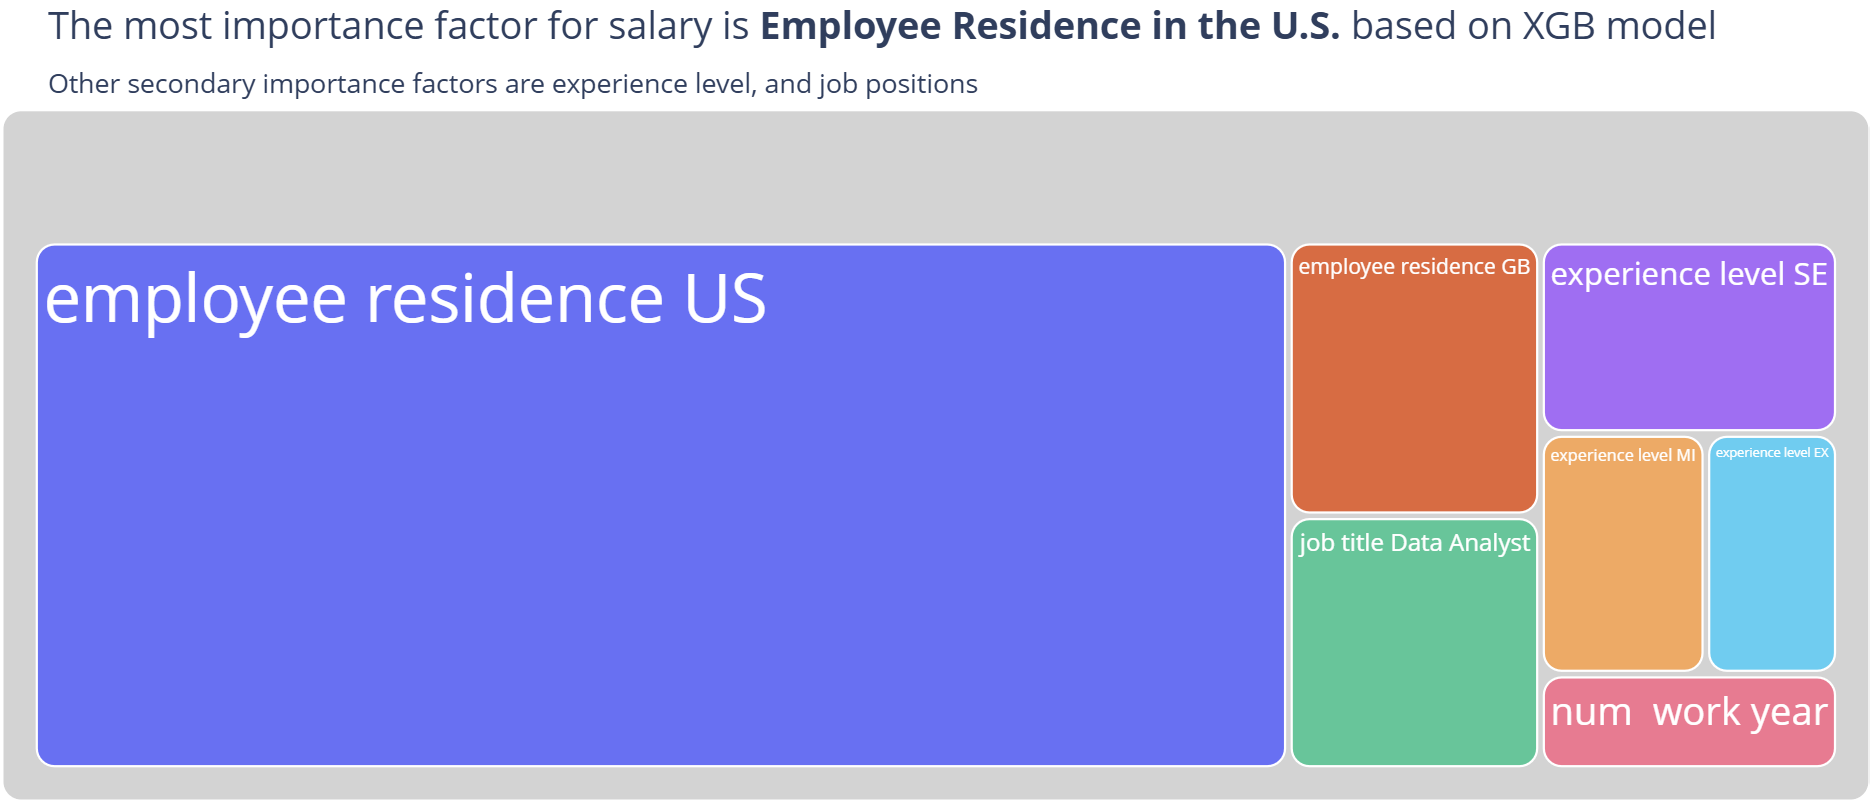

In [51]:
from IPython.display import Image
Image('newplot.png')

# Conclusion:
Although there is a high variation on salary for different data scientist positions and titles, several outstanding factors that seemed have the most impact on salary for a given position. First, company location has the biggest impact as shown by the average salary chart by countries. On average, only 5 company locations offer above the international salary line in graph 3. Second, salary also scales with work experience as expected. Third, on average medium size companies also seemed to pay more than small and large size companies. The feature importances of this dataset were used to train a XGBoost model and extracted the importance rankings. The XGBoost model confirmed that location, experience levels and also job titles have high impact on determining the salary in a given position. For Data Science job seekers, who desire above international salary average, the company and employee residence location is the number one factor followed by experience level/position. Other secondary factors could be company sizes.